In [2]:
import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.3)
import warnings
warnings.filterwarnings("ignore")
import matplotlib.ticker as ticker

import sys

sys.path.insert(0, '/home/was966/Research/mims-conceptor/')
from conceptor.utils import plot_embed_with_label
from conceptor import PreTrainer, FineTuner, loadconceptor #, get_minmal_epoch
from conceptor.utils import plot_embed_with_label, plot_performance, score2
from conceptor.tokenizer import CANCER_CODE

In [3]:
mfile = '../../checkpoint/latest/pretrainer.pt'
pretrainer = loadconceptor(mfile)

data_path = '../../00_data/'
df_label = pd.read_pickle(os.path.join(data_path, 'ITRP.PATIENT.TABLE'))

df_tpm = pd.read_pickle(os.path.join(data_path, 'ITRP.TPM.TABLE'))[pretrainer.feature_name]
df_tpm.shape, df_label.shape

((1133, 15672), (1133, 110))

In [4]:
dfcx = df_label.cancer_type.map(CANCER_CODE).to_frame('cancer_code').join(df_tpm)
cohorts = df_label.groupby('cohort').size().sort_values().index.tolist()

dfcx = df_label.cancer_type.map(CANCER_CODE).to_frame('cancer_code').join(df_tpm)
dfgeneset, dfcelltype = pretrainer.extract(dfcx, batch_size=16)
dfg_feat, dfc_feat = pretrainer.project(dfcx, batch_size=16)

100%|##########| 71/71 [00:12<00:00,  5.63it/s]


In [5]:
cohort = df_label[df_label.cohort == 'SU2CLC1']
x = 'Immune phenotype'

dfp = pd.read_csv('./SU2CLC1_phenotype.tsv', index_col=0, sep='\t')
cohort[x] = cohort.Sample_id.map(dfp.Phenotype)

In [6]:
cohort[x].sort_values()

Index
NSCLC_Ravi_SU2CLC-DFC-DF0499-T1        activated
NSCLC_Ravi_SU2CLC-COL-1044-T1          activated
NSCLC_Ravi_SU2CLC-DFC-1536-T1          activated
NSCLC_Ravi_SU2CLC-DFC-DF0108-T1        activated
NSCLC_Ravi_SU2CLC-DFC-DF0241-T1        activated
                                       ...      
NSCLC_Ravi_SU2CLC-MGH-1149-T1      wound healing
NSCLC_Ravi_SU2CLC-COL-1022-T1      wound healing
NSCLC_Ravi_SU2CLC-MGH-1163-T1      wound healing
NSCLC_Ravi_SU2CLC-MGH-1411-T1      wound healing
NSCLC_Ravi_SU2CLC-MDA-1628-T1      wound healing
Name: Immune phenotype, Length: 102, dtype: object

In [7]:
cohort[x].sort_values().unique()

array(['activated', 'desert', 'wound healing'], dtype=object)

In [8]:
dfcelltype.columns

Index(['CANCER', 'Bcell_general', 'Memory_Bcell', 'Naive_Bcell', 'Plasma_cell',
       'CD4_Tcell', 'CD8_Tcell', 'Memory_Tcell', 'Naive_Tcell',
       'Tcell_general', 'Cytotoxic_Tcell', 'Exhausted_Tcell',
       'Immune_checkpoint', 'Treg', 'NKcell', 'Innate_lymphoid_cell', 'cDC',
       'pDC', 'Macrophage', 'Monocyte', 'Myeloid', 'Granulocyte', 'Mast',
       'Erythrocyte', 'Platelet', 'Stem', 'Stroma', 'Pericyte', 'Fibroblast',
       'Endothelial', 'Epithelial', 'Mesothelial', 'Adipocyte', 'Hepatocyte',
       'Pancreatic', 'Pneumocyte', 'Apoptosis_pathway', 'IFNg_pathway',
       'TGFb_pathway', 'Cytokine', 'Cell_proliferation', 'TLS',
       'Genome_integrity', 'Reference'],
      dtype='object')

In [9]:
palette = sns.palettes.color_palette('tab10', 4)
palette = [palette[1], palette[0], palette[2]]
sns.palettes.color_palette('tab10', 4)

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)]

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

desert
(n=24) vs. activated
(n=36): Mann-Whitney-Wilcoxon test two-sided, P_val:1.372e-01 U_stat=5.310e+02
activated
(n=36) vs. wound healing
(n=42): Mann-Whitney-Wilcoxon test two-sided, P_val:2.528e-06 U_stat=1.226e+03
desert
(n=24) vs. wound healing
(n=42): Mann-Whitney-Wilcoxon test two-sided, P_val:2.982e-06 U_stat=8.550e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

desert
(n=24) vs. activated
(n=36): Mann-Whitney-Wilcoxon test two-sided, P_val:9.819e-01 U_stat=4.340e+02
activated
(n=36) vs. wound healing
(n=42): Mann-Whitney-Wilcoxon test two-sided, P_val:4.267e-07 U_stat=1.261e+03
desert
(n=24) vs. wound healing
(n=42): Mann-Whitney-Wilcoxon t

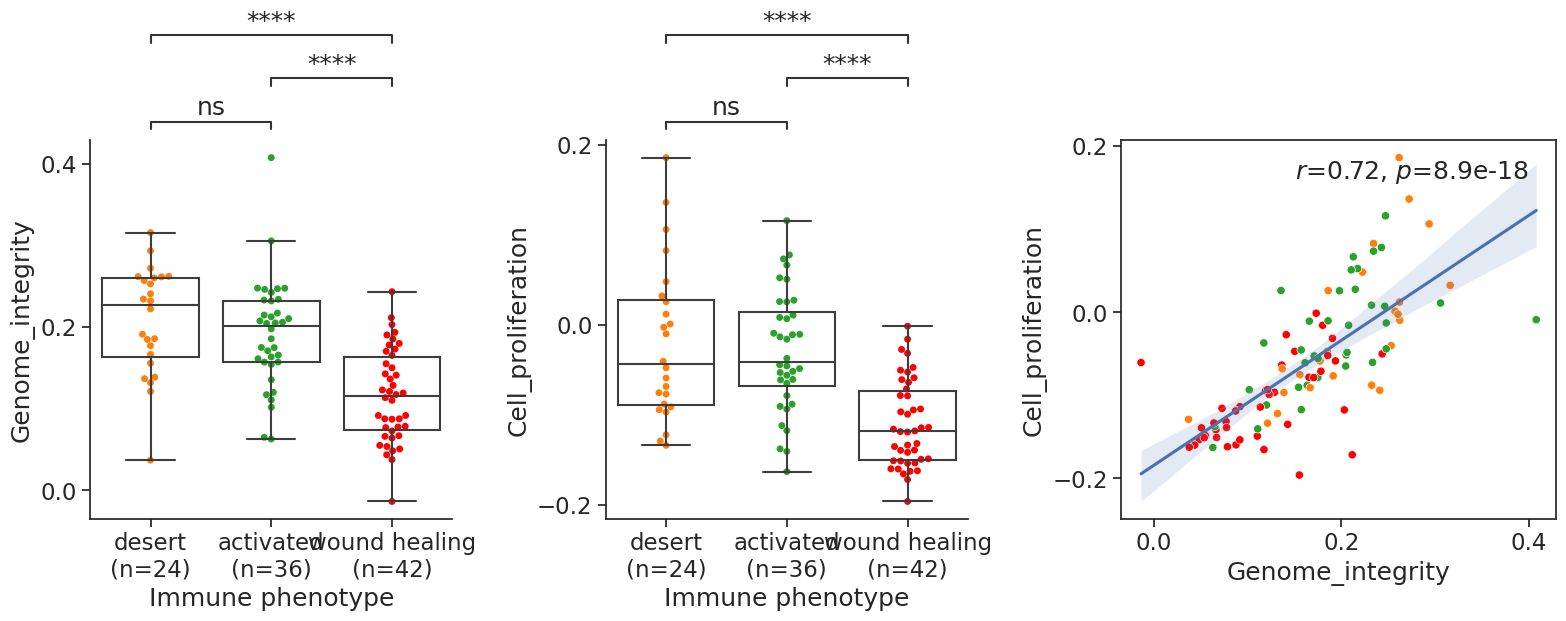

In [10]:
y1 = 'Genome_integrity'
y2 = 'Cell_proliferation'
x_order = [ 'desert','activated','wound healing']
box_pairs = [('desert', 'wound healing'), ('desert', 'activated'), ('wound healing', 'activated')]
data = cohort[[x]].join(dfcelltype[[y1,y2]])
size = data.groupby(x).size()
size = size.index + "\n(n=" + size.astype(str) + ')'
phenotype_map = size.to_dict()
data[x] = data[x].map(phenotype_map)
x_order = pd.Series(x_order).map(phenotype_map).tolist()

box_pairs = [(x_order[i], x_order[j]) for i in range(len(x_order)) for j in range(i+1, len(x_order))]



import scipy
from statannotations.Annotator import Annotator
def annotate(ax, data, x, y):
    slope, intercept, rvalue, pvalue, stderr = scipy.stats.linregress(x=data[x], y=data[y])
    ax.text(.4, .9, f'$r$={rvalue:.2f}, $p$={pvalue:.2g}', transform=ax.transAxes)
    

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(16, 7), ncols=3, width_ratios = [1,1,1.2])

palette = sns.palettes.color_palette('tab10', 4)
palette = [ palette[1], palette[2], 'red']


sns.boxplot(data = data, x = x, y = y1, 
            order = x_order, ax=ax1, width = .8, palette = palette, fliersize=0,  boxprops={'facecolor':'None'})
sns.boxplot(data = data, x = x, y = y2, 
            order = x_order, ax=ax2, width = .8, palette = palette, fliersize=0,  boxprops={'facecolor':'None'})

sns.swarmplot(data = data, x = x, y = y2, 
            order = x_order, ax=ax2,  palette = palette,  zorder=.5)

sns.swarmplot(data = data, x = x, y = y1, 
            order = x_order, ax=ax1,  palette = palette, zorder=.5)


annotator = Annotator(ax1, pairs=box_pairs, data=data, x=x, y=y1, order=x_order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', comparisons_correction = None,)
annotator.apply_and_annotate()

annotator = Annotator(ax2, pairs=box_pairs, data=data, x=x, y=y2, order=x_order)
annotator.configure(test='Mann-Whitney', text_format='star',  loc='outside', comparisons_correction = None,)
annotator.apply_and_annotate()


sns.scatterplot(data = data, x = y1, y = y2,  hue = x, ax=ax3, legend = False, 
                palette = palette, hue_order = x_order)
sns.regplot(data=data, x=y1, y=y2, scatter=False, ax=ax3)
annotate(ax3, data, y1, y2)

for ax in [ax1, ax2]:
    ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
    # ax.set_xticklabels(
    #     x_order, 
    #     rotation=1, 
    #     ha="right",  
    #     rotation_mode="anchor")  # <====== HERE is the ke

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


ax3.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
    
ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax3.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax3.xaxis.set_major_locator(ticker.MultipleLocator(0.2))

    
fig.tight_layout()

fig.savefig('SU2CLC1_score_phenotype_wound_healiing.pdf')

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

desert
(n=24) vs. activated
(n=36): Mann-Whitney-Wilcoxon test two-sided, P_val:7.743e-07 U_stat=7.600e+02
activated
(n=36) vs. wound healing
(n=42): Mann-Whitney-Wilcoxon test two-sided, P_val:4.267e-07 U_stat=2.510e+02
desert
(n=24) vs. wound healing
(n=42): Mann-Whitney-Wilcoxon test two-sided, P_val:5.008e-01 U_stat=5.550e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

desert
(n=24) vs. activated
(n=36): Mann-Whitney-Wilcoxon test two-sided, P_val:4.479e-07 U_stat=9.700e+01
activated
(n=36) vs. wound healing
(n=42): Mann-Whitney-Wilcoxon test two-sided, P_val:1.028e-06 U_stat=1.244e+03
desert
(n=24) vs. wound healing
(n=42): Mann-Whitney-Wilcoxon t

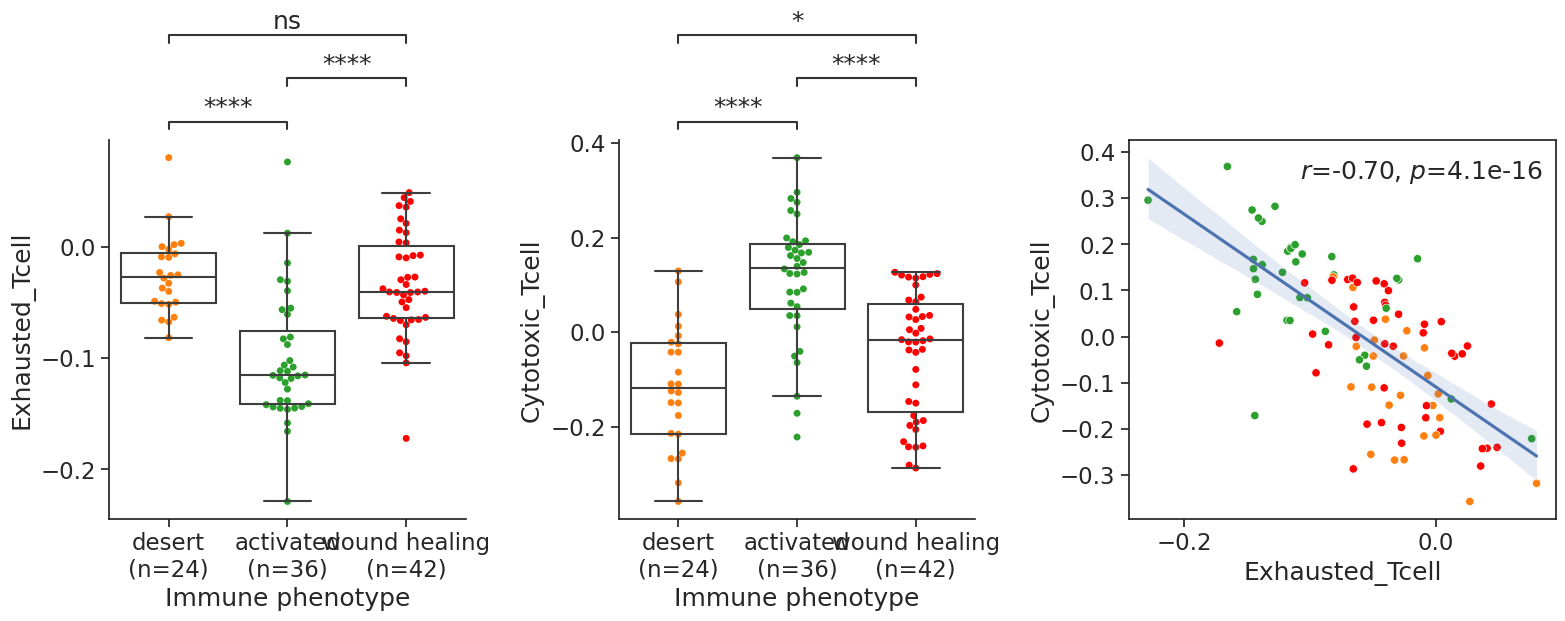

In [16]:
y1 = 'Exhausted_Tcell' #'', ''
y2 = 'Cytotoxic_Tcell'
x_order = [  'desert','activated', 'wound healing']
box_pairs = [('desert', 'wound healing'), ('desert', 'activated'), ('wound healing', 'activated')]
data = cohort[[x]].join(dfcelltype[[y1,y2]])
size = data.groupby(x).size()
size = size.index + "\n(n=" + size.astype(str) + ')'
phenotype_map = size.to_dict()
data[x] = data[x].map(phenotype_map)
x_order = pd.Series(x_order).map(phenotype_map).tolist()

box_pairs = [(x_order[i], x_order[j]) for i in range(len(x_order)) for j in range(i+1, len(x_order))]



import scipy
from statannotations.Annotator import Annotator
def annotate(ax, data, x, y):
    slope, intercept, rvalue, pvalue, stderr = scipy.stats.linregress(x=data[x], y=data[y])
    ax.text(.4, .9, f'$r$={rvalue:.2f}, $p$={pvalue:.2g}', transform=ax.transAxes)
    

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(16, 7), ncols=3, width_ratios = [1,1,1.2])

palette = sns.palettes.color_palette('tab10', 4)
palette = [palette[1], palette[2], 'red']


sns.boxplot(data = data, x = x, y = y1, 
            order = x_order, ax=ax1, width = .8, palette = palette, fliersize=0,  boxprops={'facecolor':'None'})
sns.boxplot(data = data, x = x, y = y2, 
            order = x_order, ax=ax2, width = .8, palette = palette, fliersize=0,  boxprops={'facecolor':'None'})

sns.swarmplot(data = data, x = x, y = y2, 
            order = x_order, ax=ax2,  palette = palette,  zorder=.5)

sns.swarmplot(data = data, x = x, y = y1, 
            order = x_order, ax=ax1,  palette = palette, zorder=.5)


annotator = Annotator(ax1, pairs=box_pairs, data=data, x=x, y=y1, order=x_order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', comparisons_correction = None,)
annotator.apply_and_annotate()

annotator = Annotator(ax2, pairs=box_pairs, data=data, x=x, y=y2, order=x_order)
annotator.configure(test='Mann-Whitney', text_format='star',  loc='outside', comparisons_correction = None,)
annotator.apply_and_annotate()


sns.scatterplot(data = data, x = y1, y = y2,  hue = x, ax=ax3, legend = False, 
                palette = palette, hue_order = x_order)
sns.regplot(data=data, x=y1, y=y2, scatter=False, ax=ax3)
annotate(ax3, data, y1, y2)

for ax in [ax1, ax2]:
    ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
    # ax.set_xticklabels(
    #     x_order, 
    #     rotation=1, 
    #     ha="right",  
    #     rotation_mode="anchor")  # <====== HERE is the ke
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

ax3.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)

ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax3.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax3.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    
fig.tight_layout()

fig.savefig('SU2CLC1_score_phenotype_ex_cyc.pdf')